# Optimal interpolation module

Optimal interpolation is a tool that allows combining a spatially distributed field (i.e. the "background field") with point observations in such a way that the entire field can be adjusted according to deviations between the observations and the field at the point of observations. For example, it can be used to combine a field of reanalysis precipitation (e.g. ERA5) with observation records, and thus adjust the reanalysis precipitation over the entire domain in a statistically optimal manner. 

This page demonstrates how to use `xhydro` to perform optimal interpolation using field-like simulations and point observations for hydrological modelling. In this case, the background field is a set of outputs from a distributed hydrological model and the observations correspond to real hydrometric stations. The aim is to correct the background field (i.e. the distributed hydrological simulations) using optimal interpolation, as in Lachance-Cloutier et al (2017).

*Lachance-Cloutier, S., Turcotte, R. and Cyr, J.F., 2017. Combining streamflow observations and hydrologic simulations for the retrospective estimation of daily streamflow for ungauged rivers in southern Quebec (Canada). Journal of hydrology, 550, pp.294-306.*

In [1]:
import datetime as dt
from functools import partial
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import xarray as xr
from scipy.stats import norm

import xhydro.optimal_interpolation.optimal_interpolation_fun as opt
from xhydro.optimal_interpolation.ECF_climate_correction import general_ecf

/home/richard/miniconda3/envs/xhydro/lib/python3.11/site-packages/clisops/core/regrid.py:42: UserWarning: xarray version >= 2023.03.0 is not supported for regridding operations with cf-time indexed arrays. Please use xarray version < 2023.03.0. For more information, see: https://github.com/pydata/xarray/issues/7794.
  warnings.warn(


## A quick example

Imagine a scenario where we have 3 streamflow observation stations and a hydrological model that simulated flows at those 3 sites and at another extra 2 sites (for a total of 5 simulation sites). We would like to improve the quality of the simulations at each of the 5 sites and even more so at the 2 extra sites where there are no observations to help train the model. The setup could look something like this:

* Station 1: Observed + simulated
* Station 2: Observed + simulated
* Station 3: Observed + simulated
* Station 4: Simulated only
* Station 5: Simulated only

Optimal interpolation can help, but we will need some basic information with respect to each of the stations (simulated and observed):

* Catchment areas (to scale the errors)
* Catchment latitude / longitudes, to develop the spatial error model
* Observed data at the 3 gauged locations
* Simulated data at the 5 locations

Let's define these now and show the stations on a map:  

In [2]:
# Define the station coordinates. Start with observed (Stations 1-3)
lat_obs = np.array([45.0, 45.5, 45.8])
lon_obs = np.array([-71.0, -70.4, -71.8])

# And now the simulated (Stations 1-5). Notice that the first three stations are the same as
# the observation stations.
lat_est = np.array([45.0, 45.5, 45.8, 44.2, 45.4])
lon_est = np.array([-71.0, -70.4, -71.8, -70.2, -71.9])

# We need catchment areas to scale data, in the same order as the latitudes and longitudes.
drainage_area = np.array([480.0, 270.0, 620.0, 1000.0, 700.0])

# We also need streamflow data for each site. In this example, we will use a single day, but
# it would be possible to apply to each day of a time series. Notice that while the first three
# stations correspond to the same stations for both the observed_flow and simulated_flow data,
# The data is different because one is observed and the other is simulated.
observed_flow = np.array([100.0, 110.0, 150.0])
simulated_flow = np.array([108.0, 135.0, 148.0, 154.0, 88.0])

![test](../../docs/_static/_images/test_station_locations_OI.png)

We now have the basic data required to start processing using optimal interpolation. However, before doing so, we must provide some hyperparameters. Some are more complex than others, so let's break down the main steps.

The first is the need to compute differences (also referred to as "departures" between observations and simulations where they both occur simultaneously. We also need to scale the data by the catchment area to ensure errors are relative and can then be interpolated. We then take the logarithm of these values to ensure extrapolation does not cause negative streamflow. We will reverse the transformation later.

In [3]:
# Log-transform the scaled flow data
scaled_simulated_flow = np.log(simulated_flow / drainage_area)
scaled_observed_flow = np.log(observed_flow / drainage_area[0:3])

# Compute the departure for the three observation stations.
departures = scaled_simulated_flow[0:3] - scaled_observed_flow

We will now need some information that may (or may not) be available for our observation sites and simulation sites. These include estimates of:

* The variance of the observations at the gauged sites.
* The variance of the simulated flows at the observation sites. This is a vector of size 3 in this example, i.e. one value per observation site. Note that this variance is that of the simulations at the observation sites, and not the variance of the observations themselves.
* The variance of the simulated flows at the estimation sites. This is a vector of size 5 in this example, i.e. one value per simulation point, including those that also correspond to an observation site.

We do not know these values for this test example, however these values can be estimated in real-world applications using long time series of log-transformed and scaled flows or using measurement error from the instrumentation at gauged sites. For this example, we will assume simple values of 1.0 for each case.

In [4]:
# Define the ratio of the observed variance to that of the simulations. We set it to 0.15, but it could be adjusted
# according to the level of confidence in each measure.
var_obs = np.array([0.15, 0.15, 0.15])

# Define the background field (simulations) variance at the observed sites
bg_var_obs = (np.array([1.0, 1.0, 1.0]),)

# Define the background field (simulations) variance at the simulated sites. Note that the first three stations
# are the same as in the previous variable, as in our test case, the first three simulated stations are located
# at the observation sites.
bg_var_est = (np.array([1.0, 1.0, 1.0, 1.0, 1.0]),)

If we had better estimates of these variables, we could change the 1.0 values to more appropriate values. However, these can also be adjusted according to past experience or by trial-and-error.

The final piece of the puzzle is that of the error covariance function. In a nutshell, optimal interpolation will consider the distance between an observation (or multiple observations) and the site where we need to estimate the new flow value. We can easily understand that a simulation station that is very close to an observation station should be highly correlated with it, whereas a more distant point would be less correlated. We therefore need a covariance function that estimates (1) the degree of covariability between an observed and simulated point as a function of (2) the distance between those points. This is the ECF function, multiple models of which exist in the literature. In many instances, a model form will be imposed and parameters will be adjusted such that the model represents the existing covariance between points.

In this test example, we have too few points and not enough timesteps to establish a meaningful model (and parameterization) from the data. We therefore impose a model. There are four that are built into `xhydro`, where par[0] and par[1] are the model parameters to be calibrated (in normal circumstances) and where *h* is the distance between the points:

* Model 1: par[0] * (1 + h / par[1]) * exp(-h / par[1]) -- From Lachance-Cloutier et al. 2017.
* Model 2: par[0] * exp(-0.5 * (h / par[1])**2)
* Model 3: par[0] * exp(-h / par[1])
* Model 4: par[0] * exp(-(h ** par[1]) / par[0])

 We will use model #4, but you can change it below and see how it affects results. Parameters can also be changed to assess their impacts. 

In [5]:
# Define the ECF function model. We use partial functions to do so, with the models being predefined in the
# xhydro.optimal_interpolation.ECF_climate_correction package.
ecf_fun = partial(general_ecf, form=4)

# Now we can parameterize the ecf_fun with the model parameters that we want.
# In this test example we will use values of 1.0 and 0.5 for par[0] and par[1], respectively.
par = [1.0, 0.5]
ecf = partial(ecf_fun, par=par)

We can now run the optimal interpolation algorithm and retrieve the estimated value and variance of the uncertainty for each simulated site.

In [6]:
print("lat_est: " + str(lat_est))
print("lon_est: " + str(lon_est))
print("lat_obs: " + str(lat_obs))
print("lon_obs: " + str(lon_obs))
print("bg_departures: " + str(departures))
print("bg_est: " + str(scaled_simulated_flow))
print("bg_var_obs: " + str(bg_var_obs))
print("bg_var_est: " + str(bg_var_est))
print("var_obs: " + str(var_obs))
print("ecf: " + str(ecf))

lat_est: [45.  45.5 45.8 44.2 45.4]
lon_est: [-71.  -70.4 -71.8 -70.2 -71.9]
lat_obs: [45.  45.5 45.8]
lon_obs: [-71.  -70.4 -71.8]
bg_departures: [ 0.07696104  0.20479441 -0.01342302]
bg_est: [-1.49165488 -0.69314718 -1.4325072  -1.87080268 -2.07374352]
bg_var_obs: (array([1., 1., 1.]),)
bg_var_est: (array([1., 1., 1., 1., 1.]),)
var_obs: [0.15 0.15 0.15]
ecf: functools.partial(<function general_ecf at 0x7f3c486531a0>, form=4, par=[1.0, 0.5])


In [7]:
# Display all the data that will be used for the optimal interpolation:


# Launch the optimal interpolation with all the pre-established values.
v_est, var_est, _ = opt.optimal_interpolation(
    lat_est=lat_est,
    lon_est=lon_est,
    lat_obs=lat_obs,
    lon_obs=lon_obs,
    bg_departures=departures,
    bg_est=scaled_simulated_flow,
    bg_var_obs=bg_var_obs,
    bg_var_est=bg_var_est,
    var_obs=var_obs,
    ecf=ecf,
    precalcs={},  # To speedup calculations, not required here.
)

Finally, we can compute the actual best estimate value and the variance of the uncertainty distribution from these results:

In [8]:
# Transform back into absolute values and rescale by the drainage area
estimated_flow = np.exp(v_est) * drainage_area

print("Estimated values are: " + str(estimated_flow))
print("Simulated values were: " + str(simulated_flow))
print("Observed values are: " + str(observed_flow))

Estimated values are: [113.44733348 161.14678052 142.02962921 154.00037475  87.99639936]
Simulated values were: [108. 135. 148. 154.  88.]
Observed values are: [100. 110. 150.]


As a last step, here is how we can estimate the distribution of possible values at the estimation sites. The v_est is the location of the distribution, and the v_est is the variance. This means we can model the distribution and generate quantile values.

In [9]:
# Get the log-normal error model, whose variance depends on the interpolation variance and the variance of the departures.
var_bg = np.var(departures)  # Variance of the departures of the background field
var_est = (
    var_est * var_bg
)  # Complete error model that includes the interpolation variance and the departures variance.

# Using the uncertainty estimation, get the 25th percentile of the estimated flows, and un-transform
percentile_values = norm.ppf(np.array(25.0) / 100.0, loc=v_est, scale=np.sqrt(var_est))
flows_25th_percentile = np.exp(percentile_values) * drainage_area

# Do the same but with the 75th percentile.
percentile_values = norm.ppf(np.array(75.0) / 100.0, loc=v_est, scale=np.sqrt(var_est))
# Get the values in real units and scale according to drainage area
flows_75th_percentile = np.exp(percentile_values) * drainage_area

print("Estimated values for the 25th percentile are: " + str(flows_25th_percentile))
print("Estimated values for the 50th percentile are: " + str(estimated_flow))
print("Estimated values for the 75th percentile are: " + str(flows_75th_percentile))

Estimated values for the 25th percentile are: [[111.26527089 158.04725979 139.29781056 144.97663776  82.84020497]]
Estimated values for the 50th percentile are: [113.44733348 161.14678052 142.02962921 154.00037475  87.99639936]
Estimated values for the 75th percentile are: [[115.67218928 164.30708704 144.81502252 163.58577347  93.473529  ]]




Notice that there are a few problems with the model presented here:
1. The optimal interpolation worsened the estimated results at the gauged sites compared to the raw simulation.
2. The 25th and 75th percentile values for the estimated flows at the gauged sites are "nan".
3. The estimated flows at the ungauged sites did not change (or changed very little).

These problems arise due to some methodological choices:
* Forcing of a covariance function model and parameterization that is inadequate.
* Very few observation stations, making it extremely difficult to assess spatial patterns.
* Simulated and observed flows that were randomly generated and have no (or little) correlation, very small covariance.

This means the problem is ill-defined and the optimal interpolation should not be applied in these cases. With more data, the results become much better, as will be shown in the next section.

## Application on real data from the HYDROTEL hydrological model

The previous section showed how to implement the optimal interpolation algorithm in a standalone manner. However, this is inconvenient when many stations are to be processed concurrently. Tools have thus been built into `xhydro` to help with all the processing, and as such, has some specific data requirements. Here we explore the contents of a complete input file, and we will add details a bit later. Let's start by importing some test data from the `xhydro-testdata` repository:

In [10]:
# Get data with pooch
test_data_path = pooch.retrieve(
    url="https://github.com/hydrologie/xhydro-testdata/raw/main/data/optimal_interpolation/OI_data_corrected.zip",
    known_hash="md5:acdf90b78b53595eb97ff0e84fc07aa8",
)

# Extract to a cache path.
directory_to_extract_to = Path(test_data_path).parent
with ZipFile(test_data_path, "r") as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Read-in all the files and set to paths that we can access later.
flow_obs_info_file = directory_to_extract_to / "A20_HYDOBS_TEST_corrected.nc"
flow_sim_info_file = directory_to_extract_to / "A20_HYDREP_TEST_corrected.nc"
corresponding_station_file = directory_to_extract_to / "station_correspondence.nc"
selected_station_file = (
    directory_to_extract_to / "stations_retenues_validation_croisee.csv"
)

We now have 4 files:
- flow_obs_info_file: The dataset file (.nc) that contains the point observations and station metadata.
- flow_sim_info_file: The dataset file (.nc) that contains the background field simulations, including simulated station metadata.
- corresponding_station_file: The dataset file (.nc) that links the station identifiers between observations and simulated stations. This is necessary because observed stations have "real world" identifiers and distributed simulations are often coded or numbered sequentially. However, we need to be able to find which of the background field stations (simulation points) correspond to each real-world station.
- selected_station_file: The list of stations from the observation set that we wish to use (thus discarding the others from the flow_obs_info_file set).

We can now process them to extract some values that will be required to send to the optimal interpolation main controller:

In [11]:
# We first open the .nc files that contain our required data (qobs for the observed flows,
# qsim for the simulated flows and the station correspondence file)
qobs = xr.open_dataset(flow_obs_info_file)
qsim = xr.open_dataset(flow_sim_info_file)
station_correspondence = xr.open_dataset(corresponding_station_file)

# Also read the .csv file that contains the list of observation stations to include.
df_validation = pd.read_csv(selected_station_file, sep=None, dtype=str)
observation_stations = list(df_validation["No_station"])

Let's explore the contents of these files:

In [12]:
# First show the contents of the observed streamflow file:
display(qobs)

<xarray.Dataset>
Dimensions:        (time: 1097, station: 274)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2019-01-01
    lat            (station) float32 ...
    lon            (station) float32 ...
    station_id     (station) object ...
Dimensions without coordinates: station
Data variables:
    drainage_area  (station) float32 ...
    centroid_lat   (station) float32 ...
    centroid_lon   (station) float32 ...
    classement     (station) float32 ...
    streamflow     (station, time) float64 ...
Attributes: (12/13)
    title:                          Observations hydrométriques aux stations ...
    summary:                        Streamflow measurement at water gauge of ...
    institution:                    DEH (Direction de l'Expertise Hydrique)
    institute_id:                   DEH
    contact:                        simon.lachance-cloutier@environnement.gou...
    date_created:                   2020-10-13
    ...                             ...
    featureType:                    timeSeries
    cdm_data_type:                  station
    license:                        ODC-BY
    keywords:                       hydrology, Quebec, observed, streamflow, ...
    conventions:                    CF-1.6
    project_internal_codification:  CQ2

### IMPORTANT: 
Notice that there are a few keywords that are important in these files that the code expects:
1. The streamflow observations must be in a data variable named "streamflow", with dimensions "station" and "time".
2. There must be the catchment drainage area in a variable named "drainage_area" with dimensions "station".
3. The "centroid_lat" and "centroid_lon" are also required under those specific names to allow computing distances. These are the centroids of the catchments, and not the latitude and longitude of the hydrometric stations.
4. There should be a "time" variable.
5. There should be a "station_id" variable, that has an identifier for each station. This will be used to map the observation station IDs to the simulated station IDs using the correspondence tables.

Notice that there are 274 observed stations, which should help increase the error covariance function's accuracy.

We can now explore the simulated streamflow "qsim", which is quite similar:


In [13]:
# Next show the contents of the simulated streamflow file:
display(qsim)

<xarray.Dataset>
Dimensions:        (time: 1097, station: 274)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2019-01-01
    lat            (station) float32 ...
    lon            (station) float32 ...
    station_id     (station) object ...
Dimensions without coordinates: station
Data variables:
    drainage_area  (station) float32 ...
    streamflow     (station, time) float32 ...

### IMPORTANT:
We can again see some specific variables in the "qsim" dataset:
1. The streamflow simulations must be in a data variable named "streamflow", with dimensions "station" and "time".
2. There must be the catchment drainage area *as simulated by the model* in a variable named "drainage_area" with dimensions "station".
3. The "lat" and "lon" are also required under those specific names to allow computing distances. These are the centroids of the catchments, and not the latitude and longitude of the hydrometric stations, which do not exist in the simulation mode.
4. There should be a "time" variable.
5. There should be a "station_id" variable, that has an identifier for each station. This will be used to map the observation station IDs to the simulated station IDs using the correspondence tables.

Notice that there are again 274 stations, like in the "qobs" dataset. This is because this specific dataset was used to perform leave-one-out cross validation to assess the optimal interpolation performance, and as such, only simulations at gauged sites is of interest. In an operational setting, there is no limit on the number of stations for "qsim".

Now let's take a look at the correspondance tables and the observed station dataset.

In [14]:
# Show the correspondence table
display(station_correspondence)

<xarray.Dataset>
Dimensions:     (station: 296)
Dimensions without coordinates: station
Data variables:
    reach_id    (station) object ...
    station_id  (station) object ...

To keep the observed and simulation station names separate, the following nomenclature has been adopted:

- Observed stations are tagged as "station_id" in the station_correspondence dataset
- Simulated stations are tagged as "reach_id" in the station_correspondence dataset

Notice that there are 296 stations in this table, whereas we only had 274 stations in the flow datasets. This is completely acceptable, as long as all observed-simulation pairs are found in the station_correspondence dataset. If some are missing, the code will raise an exception.

Finally, let's see the contents of the observation_stations variable, which tells the model which of the 274 observation stations should be used to build the error covariance model and perform the optimal interpolation. These stations need to be a subset of the 274 observed stations.

In [15]:
print(
    "There are a total of "
    + str(len(observation_stations))
    + " selected observation stations."
)
print(observation_stations)

There are a total of 96 selected observation stations.
['011508', '011509', '020602', '020802', '021601', '021915', '021916', '022003', '022301', '022601', '022704', '023303', '023401', '023402', '023702', '024003', '024007', '024010', '024014', '024015', '030101', '030103', '030215', '030234', '030282', '030335', '030345', '030424', '030425', '030905', '030907', '030919', '030921', '040129', '040204', '040841', '040830', '040840', '041902', '041903', '042103', '043012', '050144', '050135', '050304', '050408', '050409', '050702', '050801', '050812', '050915', '050916', '051001', '051005', '051006', '051301', '051502', '052228', '052231', '052601', '052606', '052805', '060101', '060102', '060202', '060601', '060704', '060901', '061020', '061022', '061024', '061028', '061307', '061502', '061801', '061901', '061905', '061909', '062102', '062114', '062701', '062803', '070401', '072301', '073502', '073503', '073801', '074701', '074902', '075702', '075705', '076201', '076601', '080101', '080

As can be seen, it is simply a list of stations. It can be generated by any means by users, as long as it is in list form and includes stations from the qobs "station_id" variables. For this test case, we used only 96 catchments that had a sufficient number of observed streamflow records.

We can now provide more details on some hyperparameters. Note that many of the hyperparameters of the test example are not required here, as the model will impose some choices and determine other values from the data directly. For example, the ECF model used is 'Model 3', and its parameters are optimized to best fit the available data.

At this stage, the only missing required data is as follows:

In [16]:
# Start and end dates for the simulation. We use a short period for this notebook, but it can be extended.
start_date = dt.datetime(2018, 11, 1)
end_date = dt.datetime(2019, 1, 1)

# The ratio of observed-to-simulated variance.
ratio_var_bg = 0.15

# The percentiles desired to estimate the flow uncertainty at each timestep and station
percentiles = [25.0, 50.0, 75.0]

# The number of variogram bins required to fit the error covariance function. 10 is a good number, but could be increased with more data.
variogram_bins = 10

We can now do a bit of processing to ensure we only provide the desired data:

In [17]:
# Extract only the desired time period for the flow datasets
qobs = qobs.sel(time=slice(start_date, end_date))
qsim = qsim.sel(time=slice(start_date, end_date))

# Other computational options

# If we do a leave-one-out cross-validation over the 96 catchments, the entire optimal interpolation process is repeated 96 times but
# only over the observation sites, each time leaving one station out and kept independent for validation. This is time-consuming and
# can be parallelized by adjusting this flag and setting an appropriate number of CPU cores according to your computer. By default,
# the code will only use 1 core. However, if increased, the maximum number tht will be actually used is ([number-of-available-cores / 2] - 1)
# CPU cores as to not overexert the computer.
parallelize = False
max_cores = 1

# However, if leave_one_out_cv is set to False, then a simple operational application is performed and the model will estimate flows
# at all of the "qsim" simulation sites. Here we set to "True" to generate a Leave-One-Out Cross-Validation and thus get flows that can
# be evaluated and compared to actual observations.
leave_one_out_cv = True

We are now ready to perform the optimal interpolation, return the results in the form of a dataset, and explore that dataset:

In [18]:
# Launch the optimal interpolation by calling the main controller
ds = opt.execute_interpolation(
    qobs=qobs,
    qsim=qsim,
    station_correspondence=station_correspondence,
    observation_stations=observation_stations,
    ratio_var_bg=ratio_var_bg,
    percentiles=percentiles,
    variogram_bins=variogram_bins,
    parallelize=parallelize,
    max_cores=max_cores,
    leave_one_out_cv=leave_one_out_cv,
)

display(ds)

<xarray.Dataset>
Dimensions:        (percentile: 3, station_id: 96, time: 62, station: 96,
                    nbnds: 2)
Coordinates:
  * percentile     (percentile) float64 25.0 50.0 75.0
  * station        (station) <U6 '011508' '011509' ... '080106' '080707'
Dimensions without coordinates: station_id, time, nbnds
Data variables:
    streamflow     (percentile, station_id, time) float64 2.124 2.058 ... 334.6
    lat            (station_id) float64 48.55 48.4 49.04 ... 48.21 47.99 48.73
    lon            (station_id) float64 -67.59 -67.35 -64.91 ... -77.73 -76.79
    drainage_area  (station_id) float64 555.0 2.753e+03 ... 365.0 2.228e+04
    time_bnds      (time, nbnds) datetime64[ns] 2018-10-31T23:59:59.999999999...

We can see that the returned dataset has a variable called "streamflow" of size **[percentile, station_id, time]**.

This variable can be explored to get the flow estimation for each percentile requested to assess the uncertainty. For example, let's explore the value for the 50th percentile, i.e. the percentile value at index 1.

In [19]:
display(ds["streamflow"].sel(percentile=50.0))

<xarray.DataArray 'streamflow' (station_id: 96, time: 62)>
array([[   3.06106887,    3.08482633,    3.40291866, ...,    7.21277941,
           7.17458224,    7.11689552],
       [  29.01027516,   28.1848719 ,   37.62187009, ...,   35.08815169,
          33.54158007,   32.22040804],
       [   9.59003258,    9.01568854,   12.50503336, ...,    6.63569636,
           6.23049285,    6.00326429],
       ...,
       [ 169.18115137,  203.11281048,  184.98202483, ...,   51.93455718,
          48.56459553,   60.16687057],
       [  10.93729979,   13.37748088,   11.88123852, ...,    3.16825856,
           2.96104113,    3.68364776],
       [1043.8106597 , 1291.35950895, 1219.39897879, ...,  247.07789419,
         227.94282961,  286.18602839]])
Coordinates:
    percentile  float64 50.0
Dimensions without coordinates: station_id, time
Attributes:
    long_name:              Streamflow
    standard_name:          outgoing_water_volume_transport_along_river_channel
    units:                  m3 s-1
    cell_methods:           time: mean
    coverage_content_type:  modelResult

We can go further and extract the data for one catchment. We will also store it into a separate variable for further analysis.


In [20]:
# Change to see another catchment.
selected_catchment = 0
interpolated_flow_select = (
    ds["streamflow"].sel(percentile=50.0).isel(station_id=selected_catchment)
)

# Get the station ID for comparing
interpolated_flow_select_station_id = str(
    ds["station"].isel(station=selected_catchment).data
)

We can do a similar processing for the observed and raw simulation data:

In [21]:
# Since we went from 274 to 96 catchments, the indexing is not preserved between the outputs and input files. Furthermore, there is
# no guarantee that the 274 simulation and 274 observation stations are in the same order between both files. This code realigns everything.
index_correspondence = np.where(
    station_correspondence["station_id"] == interpolated_flow_select_station_id
)[0][0]
station_code = station_correspondence["reach_id"][index_correspondence]
index_in_sim = np.where(qsim["station_id"].values == station_code.data)[0][0]
index_in_obs = np.where(qobs["station_id"] == interpolated_flow_select_station_id)[0][0]

# Extract the correct data from the observed and raw simulation files.
observed_flow_select = qobs["streamflow"].isel(station=index_in_obs)
raw_simulated_flow_select = qsim["streamflow"].isel(station=index_in_sim)

We can plot these results and look for improvement in the simulations after the optimal interpolation:


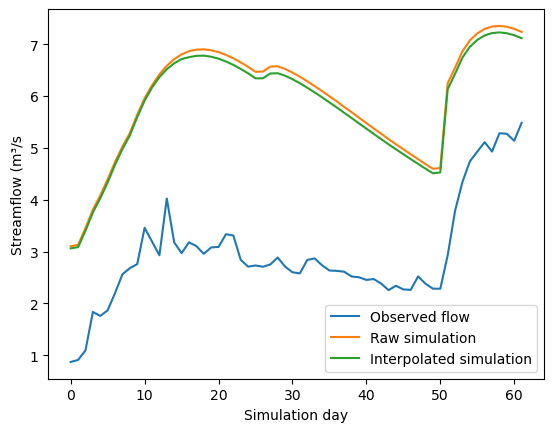

In [22]:
plt.plot(observed_flow_select, label="Observed flow")
plt.plot(raw_simulated_flow_select, label="Raw simulation")
plt.plot(interpolated_flow_select, label="Interpolated simulation")
plt.xlabel("Simulation day")
plt.ylabel("Streamflow (m³/s")
plt.legend()
plt.show()